# LAB 8 : Classification

  1. Support Vector Machines 
  2. K-Nearest Neighbors
  3. Classification on MNIST Digit 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Support Vector Machines (SVM)



1. Try to maximize the margin of separation between data.
2. Instead of learning wx+b=0  separating hyperplane directly (like logistic regression), SVM try to learn wx+b=0, such that, the margin between two hyperplanes wx+b=1 and wx+b=-1 (also known as support vectors) is maximum. 
3. Margin between wx+b=1 and wx+b=-1 hyperplane is $\frac{2}{||w||}$
4. we have a constraint optimization problem of maximizing $\frac{2}{||w||}$, with constraints wx+b>=1 (for +ve class) and wx+b<=-1 (for -ve class).
5. As $y_{i}=1$ for +ve class and $y_{i}=-1$ for -ve class, the constraint can be re-written as:
$$y(wx+b)>=1$$

6. Final optimization is (i.e to find w and b):
$$\min_{||w||}\frac{1}{2}||w||,$$
$$y(wx+b) \geq 1,~\forall ~data $$



Acknowledgement:

https://pythonprogramming.net/predictions-svm-machine-learning-tutorial/

https://medium.com/deep-math-machine-learning-ai/chapter-3-1-svm-from-scratch-in-python-86f93f853dc

## Data generation:
1. Generate 2D gaussian data with fixed mean and variance for 2 class.(var=Identity, class1: mean[-4,-4], class2: mean[1,1], No. of data 25 from each class)
2. create the label matrix
3. Plot the generated data

(50, 2)
(50,)


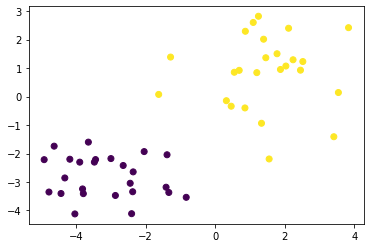

In [2]:
No_sample=50
mean1=np.array([-3,-3])
var1=np.array([[1,0],[0,1]])
mean2=np.array([1,1])
var2=var1
data1=np.random.multivariate_normal(mean1,var1,int(No_sample/2))
data2=np.random.multivariate_normal(mean2,var2,int(No_sample/2))
X=np.concatenate((data1,data2))
print(X.shape)
y=np.concatenate((-1*np.ones(data1.shape[0]),np.ones(data2.shape[0])))
print(y.shape)

plt.figure()
plt.scatter(X[:,0],X[:,1],marker='o',c=y)

Create a data dictionary, which contains both label and data points.

In [3]:
postiveX=[]
negativeX=[]

for xi, yi in zip(X, y):
	if yi==1:
		postiveX.append(xi)
	else:
		negativeX.append(xi)

#our data dictionary
data_dict = {-1:np.array(negativeX), 1:np.array(postiveX)} 

## SVM training
1. create a search space for w (i.e w1=w2),[0, 0.5*max((abs(feat)))] and  for b, [-max((abs(feat))),max((abs(feat)))], with appropriate step.
2. we will start with a higher step and find optimal w and b, then we will reduce the step and again re-evaluate the optimal one.

3. In each step, we will take transform of w, [1,1], [-1,1],[1,-1] and [-1,-1] to search arround the w. 

4. In every pass (for a fixed step size) we will store all the w, b and its corresponding ||w||, which make the data correctly classified as per the condition $y(wx+b) \geq 1$. 

5. Obtain the optimal hyperplane having minimum ||w||.

6. Start with the optimal w and repeat the same (step 3,4 and 5) for a reduced step size.


In [4]:
# it is just a searching algorithem, not a complicated optimization algorithem, (just for understanding of concepts through visualization)

def SVM_Training(data_dict):

	def isValid(w,b,data_dict):
		for yi in data_dict:
			for xi in data_dict[yi]:
				if yi*(np.dot(w,xi)+b)<1:
					return False
		return True

	data_max = max([np.abs(data_dict[i]).max() for i in data_dict])
	w_range = [0, 0.5*data_max]
	b_range = [-data_max, data_max]

	w_search = [[w, w] for w in np.linspace(w_range[0], w_range[1], 100)]
	b_search = np.linspace(b_range[0], b_range[1], 100)

	opt = None
	w_norm = 1e10

	for w in w_search:
		for b in b_search:
			for t in [[1,1], [1,-1], [-1,1], [-1,-1]]:
				w_t = np.array(w)*t
				if isValid(w_t, b, data_dict):
					new_norm = np.linalg.norm(w_t)
					if new_norm < w_norm:
						w_norm = new_norm
						opt = (w_t, b)
	return opt


**Training**

In [5]:
# All the required variables 
w=[] # Weights 2 dimensional vector
b=[] # Bias
w,b=SVM_Training(data_dict)
print(w)
print(b)

[1.09265004 1.09265004]
2.731625109083147


## Visualization of the SVM separating hyperplanes (after training)

In [6]:
def visualize(data_dict):
       
        plt.scatter(X[:,0],X[:,1],marker='o',c=y)

        # hyperplane = x.w+b
        # v = x.w+b
        # psv = 1
        # nsv = -1
        # dec = 0
        def hyperplane_value(x,w,b,v):
            return (-w[0]*x-b+v) / w[1]

        
        hyp_x_min = np.min([np.min(data_dict[1]),np.min(data_dict[-1])])
        hyp_x_max = np.max([np.max(data_dict[1]),np.max(data_dict[-1])])

        # (w.x+b) = 1
        # positive support vector hyperplane
        psv1 = hyperplane_value(hyp_x_min, w, b, 1)
        psv2 = hyperplane_value(hyp_x_max, w, b, 1)
        plt.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k')

        # (w.x+b) = -1
        # negative support vector hyperplane
        nsv1 = hyperplane_value(hyp_x_min, w, b, -1)
        nsv2 = hyperplane_value(hyp_x_max, w, b, -1)
        plt.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'k')

        # (w.x+b) = 0
        # positive support vector hyperplane
        db1 = hyperplane_value(hyp_x_min, w, b, 0)
        db2 = hyperplane_value(hyp_x_max, w, b, 0)
        plt.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')
        
        
        

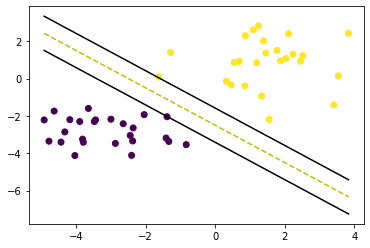

In [7]:
fig = plt.figure()
visualize(data_dict)

**Testing**

In [8]:
def predict(data,w,b):
  y_pred = np.sign(np.dot(np.array(data),w)+b)
  return y_pred

test accuracy= 100.0


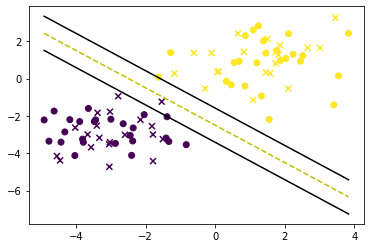

In [9]:
No_test_sample=40
data1=np.random.multivariate_normal(mean1,var1,int(No_test_sample/2))
data2=np.random.multivariate_normal(mean2,var2,int(No_test_sample/2))
test_data=np.concatenate((data1,data2))
y_gr=np.concatenate((-1*np.ones(data1.shape[0]),np.ones(data2.shape[0])))

# evaluate with the trained model

y_pred = predict(test_data,w,b)
accuracy = np.sum(y_pred==y_gr)/len(y_gr)
print('test accuracy=',accuracy*100)

#  Visualization
plt.figure()
visualize(data_dict)
plt.scatter(test_data[:,0],test_data[:,1],marker='x',c=y_gr)
plt.show()

**Use the Sci-kit Learn Package and perform Classification on the above dataset using the SVM algorithm**

[0.73343824 1.02692669]
2.115098954968477


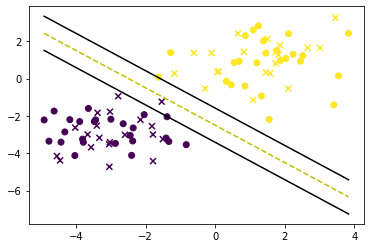

test accuracy= 1.0


In [10]:
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X, y)

w_sklearn = clf.coef_[0]
b_sklearn = clf.intercept_[0]

print(w_sklearn)
print(b_sklearn)

plt.figure()
visualize(data_dict)
plt.scatter(test_data[:,0],test_data[:,1],marker='x',c=y_gr)
plt.show()

y_pred = predict(test_data,w_sklearn,b_sklearn)
accuracy = np.sum(y_pred==y_gr)/len(y_gr)
print('test accuracy=',accuracy)


# K-Nearest Neighbours (KNN)

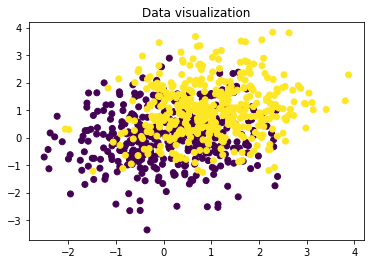

In [118]:
import numpy as np
import matplotlib.pyplot as plt

mean1=np.array([0,0])
mean2=np.array([1,1])
var=np.array([[1,0.1],[0.1,1]])
np.random.seed(0)
data1=np.random.multivariate_normal(mean1,var,500)
data2=np.random.multivariate_normal(mean2,var,500)
data_train=np.concatenate((data1[:-100,],data2[:-100]))
label=np.concatenate((np.zeros(data1.shape[0]-100),np.ones(data2.shape[0]-100)))

plt.figure()
plt.scatter(data_train[:,0],data_train[:,1],c=label)
plt.title('Data visualization')
plt.show()

In [103]:
def euclidean_distance(row1, row2):
  return np.linalg.norm(row1-row2)

In [104]:
def get_neighbors(train, label_train, test_row, num_neighbors):
	neighbors = list()
	for x, label in zip(train, label_train):
		neighbors.append((x, label))

	neighbors.sort(key=lambda tup: euclidean_distance(tup[0], test_row))

	return neighbors[:num_neighbors]

In [105]:
def predict_classification(neighbors):
	labels = [row[1] for row in neighbors]
	prediction = max(set(labels), key=lambda x: labels.count(x))

	return prediction

In [106]:
# test data generation
data_test=np.concatenate((data1[-100:],data2[-100:]))
label_test=np.concatenate((np.zeros(100),np.ones(100)))

In [107]:
K=2

pred_label=np.zeros(data_test.shape[0])
for i in range(data_test.shape[0]):
  neig=get_neighbors(data_train,label, data_test[i,:], K)
  pred_label[i]=predict_classification(neig)

accuracy=(len(np.where(pred_label==label_test)[0])/len(label_test))*100
print('Testing Accuracy=',accuracy,'%')

Testing Accuracy= 65.5 %


**Use the Sci-kit Learn Package and perform Classification on the above dataset using the K-Nearest Neighbour algorithm**

In [108]:
# Do KNN with sklearn
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=K)
clf.fit(data_train, label)

pred_label=clf.predict(data_test)
accuracy=(len(np.where(pred_label==label_test)[0])/len(label_test))*100
print('Testing Accuracy=',accuracy,'%')

Testing Accuracy= 65.5 %


# Classification on MNIST Digit Data

1. Read MNIST data and perform train-test split
2. Select any 2 Classes and perform classification task using SVM, KNN and Logistic Regression algorithms with the help of Sci-Kit Learn tool
3. Report the train and test accuracy and also display the results using confusion matrix
4. Repeat steps 2 and 3 for all 10 Classes and tabulate the results

### 2 Classes Classification

In [109]:
# Read MNIST data and select two classes
import idx2numpy
from keras.utils import np_utils
img_path = "t10k-images-idx3-ubyte"
label_path = "t10k-labels-idx1-ubyte"

Images = idx2numpy.convert_from_file(img_path)
Labels = idx2numpy.convert_from_file(label_path)

# Let us choose 3s and 7s
three_idx = np.where(Labels == 3)
seven_idx = np.where(Labels == 7)

# Flatten the images
three_img = Images[three_idx].reshape(-1, 28*28)
seven_img = Images[seven_idx].reshape(-1, 28*28)

# Concatenate the images
data = np.concatenate([three_img, seven_img], axis=0)
labels = np.concatenate([np.zeros(three_img.shape[0]), np.ones(seven_img.shape[0])])

# train and test split
split = int(0.8*data.shape[0])
data, labels = zip(*np.random.permutation(list(zip(data, labels))))
train_data = data[:split]
test_data = data[split:]
train_labels = labels[:split]
test_labels = labels[split:]

/tmp/ipykernel_45662/3233820151.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data, labels = zip(*np.random.permutation(list(zip(data, labels))))


In [110]:
# Do SVM using sklearn
from sklearn.metrics import confusion_matrix


clf = svm.SVC()
clf.fit(train_data, train_labels)

# Find train and test accuracy
train_acc = clf.score(train_data, train_labels)
test_acc = clf.score(test_data, test_labels)

print('Train accuracy=',train_acc*100)
print('Test accuracy=',test_acc*100)
print('Confusion matrix=\n',confusion_matrix(test_labels, clf.predict(test_data)))

Train accuracy= 99.6319018404908
Test accuracy= 99.01960784313727
Confusion matrix=
 [[193   4]
 [  0 211]]


In [111]:
# Do KNN using sklearn
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(train_data, train_labels)

# Find train and test accuracy
train_acc = clf.score(train_data, train_labels)
test_acc = clf.score(test_data, test_labels)

print('Train accuracy=',train_acc*100)
print('Test accuracy=',test_acc*100)
print('Confusion matrix=\n',confusion_matrix(test_labels, clf.predict(test_data)))

Train accuracy= 99.93865030674847
Test accuracy= 99.50980392156863
Confusion matrix=
 [[196   1]
 [  1 210]]


In [112]:
# Do logistic regression using sklearn
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression(solver='liblinear')
clf.fit(train_data, train_labels)

# Find train and test accuracy
train_acc = clf.score(train_data, train_labels)
test_acc = clf.score(test_data, test_labels)

print('Train accuracy=',train_acc*100)
print('Test accuracy=',test_acc*100)
print('Confusion matrix=\n',confusion_matrix(test_labels, clf.predict(test_data)))

Train accuracy= 100.0
Test accuracy= 98.0392156862745
Confusion matrix=
 [[192   5]
 [  3 208]]


## Multiclass Classification

In [113]:
# Read MNIST data
import idx2numpy
from keras.utils import np_utils
img_path = "t10k-images-idx3-ubyte"
label_path = "t10k-labels-idx1-ubyte"

Images = idx2numpy.convert_from_file(img_path)
Images = Images.reshape(-1, 28*28)
Labels = idx2numpy.convert_from_file(label_path)

# Split the data into train and test
split = int(0.8*Images.shape[0])
Images, Labels = zip(*np.random.permutation(list(zip(Images, Labels))))
train_data = Images[:split]
test_data = Images[split:]
train_labels = Labels[:split]
test_labels = Labels[split:]

/tmp/ipykernel_45662/624048274.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Images, Labels = zip(*np.random.permutation(list(zip(Images, Labels))))


In [114]:
# Do SVM using sklearn
clf = svm.SVC()
clf.fit(train_data, train_labels)

# Find train and test accuracy
train_acc = clf.score(train_data, train_labels)
test_acc = clf.score(test_data, test_labels)

print('Train accuracy=',train_acc*100)
print('Test accuracy=',test_acc*100)
print('Confusion matrix=\n',confusion_matrix(test_labels, clf.predict(test_data)))

Train accuracy= 98.725
Test accuracy= 96.35000000000001
Confusion matrix=
 [[198   0   0   0   0   1   1   0   1   0]
 [  0 228   0   1   0   1   0   0   1   0]
 [  1   0 207   2   3   1   1   2   0   0]
 [  0   0   0 177   1   2   0   2   2   0]
 [  1   0   0   0 189   0   0   0   0   5]
 [  1   0   0   4   1 175   1   0   1   0]
 [  0   1   1   0   1   1 178   0   0   0]
 [  1   2   4   0   2   0   0 199   1   3]
 [  1   0   0   3   2   2   1   1 185   0]
 [  1   0   1   2   2   0   0   2   1 191]]


In [115]:
# Do KNN using sklearn
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(train_data, train_labels)

# Find train and test accuracy
train_acc = clf.score(train_data, train_labels)
test_acc = clf.score(test_data, test_labels)

print('Train accuracy=',train_acc*100)
print('Test accuracy=',test_acc*100)
print('Confusion matrix=\n',confusion_matrix(test_labels, clf.predict(test_data)))

Train accuracy= 97.475
Test accuracy= 94.05
Confusion matrix=
 [[200   0   0   0   0   0   1   0   0   0]
 [  0 231   0   0   0   0   0   0   0   0]
 [  2   2 205   3   1   1   1   1   1   0]
 [  0   1   1 180   0   0   0   1   1   0]
 [  0   2   1   0 188   0   1   0   0   3]
 [  1   3   1  12   0 165   1   0   0   0]
 [  3   1   2   1   1   1 173   0   0   0]
 [  1   6   0   1   2   0   0 202   0   0]
 [  1   3   2  12   1  10   0   2 163   1]
 [  1   0   1   2   7   1   0  12   2 174]]


In [116]:
# Do logistic regression using sklearn
clf = LogisticRegression(solver='liblinear')
clf.fit(train_data, train_labels)

# Find train and test accuracy
train_acc = clf.score(train_data, train_labels)
test_acc = clf.score(test_data, test_labels)

print('Train accuracy=',train_acc*100)
print('Test accuracy=',test_acc*100)
print('Confusion matrix=\n',confusion_matrix(test_labels, clf.predict(test_data)))

Train accuracy= 99.675
Test accuracy= 84.25
Confusion matrix=
 [[181   0   4   2   0   2   6   0   5   1]
 [  0 223   3   0   0   0   1   0   4   0]
 [  3   3 179   8   4   5   2   3   8   2]
 [  3   1   2 146   0   7   0   1  21   3]
 [  1   0   6   5 160   4   1   2   3  13]
 [  2   3   1   9   6 138   2   2  18   2]
 [  3   1   5   3   1   9 157   0   3   0]
 [  0   2   7   6   3   5   0 181   3   5]
 [  0   5   8  11   3   8   0   0 155   5]
 [  3   0   1   6   4   3   0  10   8 165]]


/home/omp/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
